In [1]:
"""
Plot the pickles produced by poster_astrometry.py
"""
from pathlib import Path
import os
import pickle

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn
seaborn.set_style('white')  # noqa: E402
seaborn.set_context("poster")  # noqa: E402
import itertools



In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
     """Create a colorbar that obeys tight_layout, etc.

     Stolen from: http://joseph-long.com/writing/colorbars/

     Parameters
     ----------
     mappable
         Return value from e.g. `matplotlib.imshow()` or `matplotlib.scatter()`.
     """
     try:
         # QuadContourSet is not a Artist, so doesn't have `axes`
         ax = mappable.axes
     except AttributeError:
         ax = mappable.ax
     fig = ax.figure
     divider = make_axes_locatable(ax)
     cax = divider.append_axes("right", size="5%", pad=0.05)
     
     return fig.colorbar(mappable, cax=cax)

In [3]:
def uv_mean(xlim, ylim, xx, yy, uu, vv, nx, ny):
    """Compute the mean of uu and vv on a grid within bbox."""
    #ny = int(nx*(ylim[1]-ylim[0]) / (xlim[1]-xlim[0]))    NEEDS WORK FOR ROTATED CCDs
    uMean = np.zeros((nx-1, ny-1))
    vMean = np.zeros((nx-1, ny-1))
    xMean = np.zeros((nx-1, ny-1))
    yMean = np.zeros((nx-1, ny-1))
    ww = np.linspace(xlim[0], xlim[1], nx)
    hh = np.linspace(ylim[0], ylim[1], ny)
    xrange = np.array([((xx >= w0) & (xx <= w1)) for w0, w1 in zip(ww[:-1], ww[1:])], dtype=bool)
    yrange = np.array([((yy >= w0) & (yy <= w1)) for w0, w1 in zip(hh[:-1], hh[1:])], dtype=bool)
    for i, (w0, w1) in enumerate(zip(ww[:-1], ww[1:])):
        for j, (h0, h1) in enumerate(zip(hh[:-1], hh[1:])):
            inside = xrange[i] & yrange[j]
            xMean[i, j] = (w0 + w1)/2
            yMean[i, j] = (h0 + h1)/2
            uMean[i, j] = np.mean(uu[inside]) #np slicing 
            vMean[i, j] = np.mean(vv[inside])

    return xMean, yMean, uMean, vMean


def plot_quiver(xx, yy, uu, vv, ccd, label):
    """Make a quiver plot of the astrometry error vectors."""
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    color = cycle[0] if 'jointcal' in label else cycle[1]
    scale = 0.015 if 'mean' in label else 1
    
    x_size = 10*(xx.max()-xx.min()) / (yy.max()-yy.min())
    fig = plt.figure(figsize=(x_size, 10)) 
    ax = fig.add_subplot(111)
    
    cmap = ListedColormap(seaborn.color_palette('husl',256).as_hex())
    
    angle = np.nan_to_num(np.arctan2(vMean,uMean))
    Q = ax.quiver(xx, yy, uu, vv, np.degrees(angle), cmap=cmap, units='x', pivot='tail', scale=scale, width=50,
                  headwidth=4, clip_on=False)
    #Q = ax.quiver(xx, yy, uu, vv, units='x', pivot='tail', scale=scale, width=7,
    #              headwidth=4, clip_on=False, color=color)
    length = 20  #0.5/scale if 'mean' in label else 100
    key = ax.quiverkey(Q, 0.31, 0.15, length, '%s mas'%(length), angle=0,
                       coordinates='figure', labelpos='W', fontproperties={'size': 24})

    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    fig.subplots_adjust()
    colorbar(Q)
    #plt.show();

    filename = Path("plots/quiver-%s-%s.png"%(ccd, label))
#    plt.savefig(filename, bbox_extra_artists=(key,))# bbox_inches="tight")
#    plt.close(fig)

# Full Focal Plane

In [4]:

import glob
#name = 'single'
name = 'jointcal'
pattern = os.path.abspath('focalplane/%s/pickles/quiverData-%s-*.pickle'%(name, name))
files = glob.glob(pattern)

from collections import namedtuple
UVData = namedtuple("uvmean", ["x", "y", "u", "v", "xlim", "ylim"])

xMean = yMean = uMean = vMean = None
data = {}
for file in files:
    with open(os.path.expanduser(file), 'rb') as infile:
        xx, yy, uu, vv, xlim, ylim, ccd = pickle.load(infile)
        xTemp, yTemp, uTemp, vTemp = uv_mean(xlim, ylim, xx, yy, uu, vv, 10, 20)
#        data[ccd] = UVData(xTemp, yTemp, uTemp, vTemp, xlim, ylim)
        if xMean is None:
            xMean = xTemp
            yMean = yTemp
            uMean = uTemp
            vMean = vTemp
        else:
            xMean = np.vstack((xMean, xTemp))
            yMean = np.vstack((yMean, yTemp))
            uMean = np.vstack((uMean, uTemp))
            vMean = np.vstack((vMean, vTemp))

C:\Users\hsham\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\hsham\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
data = UVData(x, y, u, v)
div = UVData(x,y, du, dv)

NameError: name 'x' is not defined

In [5]:
def plot_one(fig, data, vmin=10, vmax=10):
    extent=(data.xlim[0], data.xlim[1], data.ylim[1], data.ylim[0])
    fig.imshow(data.u, data.v, extent=extent, vmin=vmin, vmax=vmax)

In [6]:
fig = plt.figure()
for ccd in data:
    plot_one(fig, data[ccd])

<Figure size 432x288 with 0 Axes>

# Single CCD

In [5]:
'''
name = 'single'
#name = 'jointcal'
file_name = os.path.abspath('focalplane/%s/pickles/quiverData-%s-6.pickle'%(name,name)) 

#openfile = open(file_name, 'rb')     #original from John
#xx, yy, uu, vv, bbox, ccd = pickle.load(openfile)

with open(os.path.expanduser(file_name), 'rb') as infile:
    #xx, yy, uu, vv, width, height, ccd = pickle.load(infile)
    xx, yy, uu, vv, xlim, ylim, ccd = pickle.load(infile)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-5-bb3c18d7b166>, line 11)

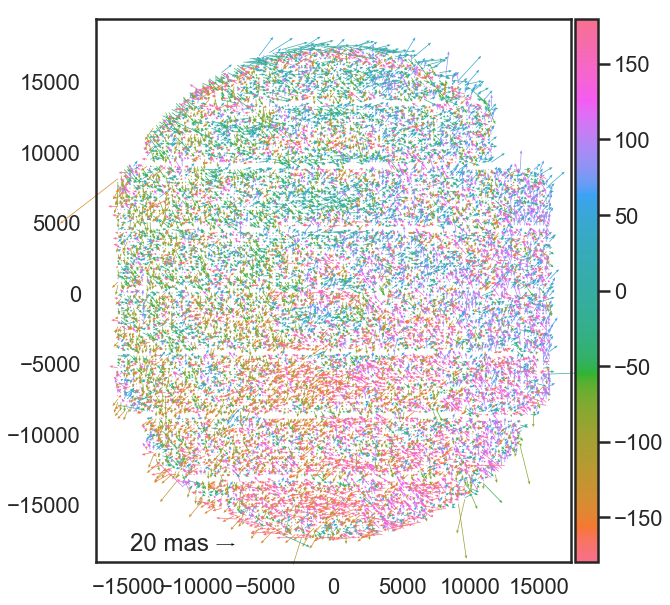

In [7]:
#xMean, yMean, uMean, vMean = uv_mean(xlim, ylim, xx, yy, uu, vv, 30, 60)

#plot_quiver(xx, yy, uu, vv, ccd, name)

plot_quiver(xMean, yMean, uMean, vMean, ccd, 'mean-'+name)


In [8]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, ColorBar, tools
import bokeh.palettes as palettes 
from bokeh.transform import linear_cmap
import astropy.units as u

#import holoviews as hv

In [9]:
arcsecperpix = .17

def bokeh_qplot(xx, yy, uu, vv):
    """
    Bokeh Quiver plot using segment()
    Inputs:
    xx,yy positions and uu,vv vector points
    Outputs:
    vectors at positions xx,yy with the ability 
    to view each vector's angle, length and 
    begining and end position on the x-y plane  
    """
    #data for plot
    x0 = xMean.flatten()
    y0 = yMean.flatten()
    length = np.nan_to_num(np.sqrt(uMean**2 + vMean**2)) * u.arcsec
    angle = np.nan_to_num(np.arctan2(vMean,uMean))
    angle_deg = angle*180/np.pi
    
    x1 = (xMean + length.value/arcsecperpix * np.cos(angle)).flatten()
    y1 = (yMean + length.value/arcsecperpix * np.sin(angle)).flatten()

    slopes = []
    for i in range(len(x0)):
        m = (y1[i]-y0[i])/(x1[i]-x0[i])
        slopes.append(m)

    #line coloring
    pal = seaborn.color_palette('husl', 21).as_hex() #palettes.'palette name'('number of colors') if using bokeh.pallets
    cm = np.array(pal) 
    ix = ((angle-angle.min())/(angle.max()-angle.min())*20).astype('int') #normalizing 
    colors = cm[ix].flatten()

    #data frame setup for hover tool
    source = ColumnDataSource(data={
        'x0'     : x0,
        'y0'     : y0,
        'x1'     : x1,
        'y1'     : y1,
        'slopes' : np.asarray(slopes),
        'angle'  : np.asarray(angle* 180/np.pi),
        'length' : np.asarray(length),
        'color'  : np.asarray(colors)
    }) #add in CCD number (ccd from pickle file show only single int=99)
    TOOLTIPS = [
        ("(x0,y0)", "(@x0{1.11}, @y0{1.11})"), #{1.11} formats as 2 decimal float
        ("(x1,y1)", "(@x1{1.11}, @y1{1.11})"),
        ("Length", "@length{%s}"), ###get astropy.units to print out
        ("Angle (deg)", "@angle{1.111}"),
    ]
    hover = tools.HoverTool(
        tooltips = TOOLTIPS,
        formatters = {
            "length" : "printf"
        }

    )

    p1 = figure( title="%s Data"%name)
    p1.title.text_font_size = "50px"
    p1.add_tools(hover)
    p1.segment('x0', 'y0', 'x1', 'y1', color='color', line_width=2, source=source, legend='unit')

    mapper = linear_cmap(field_name='angle', palette=pal ,low=min(angle_deg.flatten()) ,high=max(angle_deg.flatten()))
    color_bar = ColorBar(color_mapper=mapper['transform'], width=12,  location=(0,0))

    p1.add_layout(color_bar, 'right')

    output_file("BokehSegmentVector.html", title="BokehSegmentVector (%s)"%name)

    show(p1)

In [10]:
bokeh_qplot(xMean, yMean, uMean, vMean)

C:\Users\hsham\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
def component_plot(xMean, yMean, uMean, vMean, component):
    comp_name = "uMean" if uMean in component else "vMean"
    plt.figure(figsize=(10,10))
    plt.title('%s (Full Focal Plane)'%comp_name)
    
    basic_cols=['#ff0000', '#303030', '#0099ff']
    my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
    
    plot = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10,vmax=10 ,s=5, c=np.nan_to_num(component.flatten()), 
                       cmap=my_cmap)
    colorbar(plot);
    
    
    plt.show()
    
# plt.figure(figsize=(10,10))
# plt.title('%s (Full Focal Plane)'%component)
# basic_cols=['#ff0000', '#303030', '#0099ff']
# my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
# plot1 = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10,vmax=10 ,s=5, c=np.nan_to_num(uMean.flatten()), cmap=my_cmap)
# colorbar(plot1);

# plt.figure(figsize=(10,10))
# plt.title('vMean (Full Focal Plane)')
# plot2 = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10,vmax=10 ,s=5, c=np.nan_to_num(vMean.flatten()), cmap=my_cmap)
# colorbar(plot2);

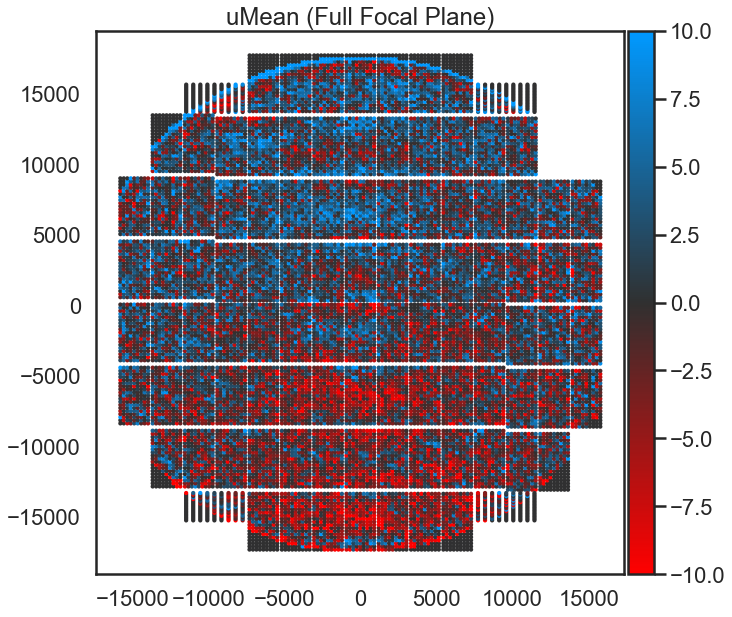

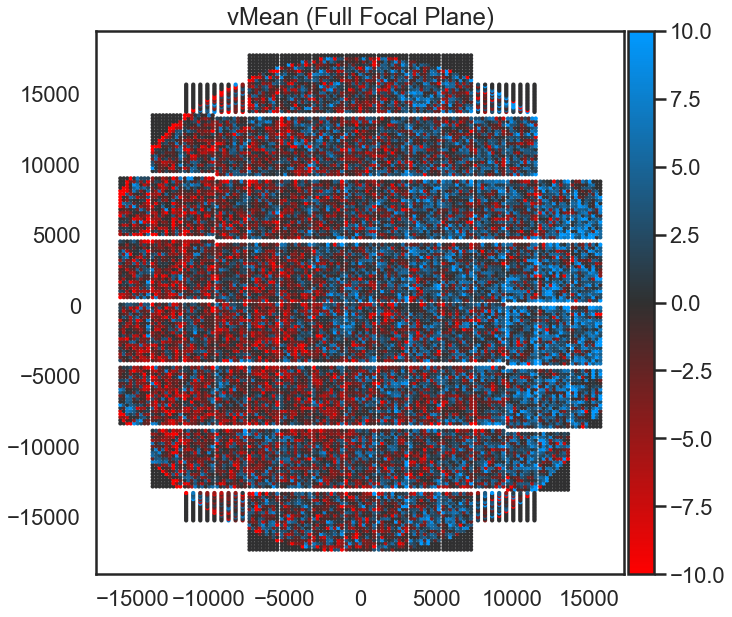

In [12]:
component_plot(xMean, yMean, uMean, vMean, uMean)
component_plot(xMean, yMean, uMean, vMean, vMean)

In [88]:
from bokeh.util.hex import hexbin
def plot_divergence(xMean, yMean, uMean, vMean, dot_size):
    uDel = np.nan_to_num(np.gradient(uMean))
    vDel = np.nan_to_num(np.gradient(vMean))
    divergence = uDel[0]+vDel[1] #dudx+dvdy
    
    #scatter plot
    plt.figure(figsize=(10,10))
    plt.title('Divergence (Full Focal Plane)')
    
    basic_cols=['#ff0000', '#303030', '#0099ff']
    my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
    
    div_plot = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10 ,vmax=10, c=divergence.flatten(),
                           s=dot_size, cmap=my_cmap)

    colorbar(div_plot);
    
        #data frame setup for hover tool
    source = ColumnDataSource(data={
        'xMean'          : xMean.flatten(),
        'yMean'          : yMean.flatten(),
        'divergence'     : divergence.flatten(),
    })
    
    
    
#     p = figure(title="Divergence" ,match_aspect=True)
#     p.background_fill_color = '#440154'
#     p.grid.visible = False
#     pal = 'Viridis256'
#     p.hex_tile('xMean', 'yMean', size=0.5, source=source, hover_color="pink", hover_alpha=0.8,
#               fill_color=linear_cmap('divergence', pal, np.min(divergence), np.max(divergence)))

#     hover = tools.HoverTool(tooltips=[("div", '@divergence'),('x','@xMean'),('y','@yMean')])
#     p.add_tools(hover)
#     mapper = linear_cmap(field_name='divergence', palette=pal ,low=min(divergence.flatten()) ,high=max(divergence.flatten()))
#     color_bar = ColorBar(color_mapper=mapper['transform'], width=12,  location=(0,0))

#     p.add_layout(color_bar, 'right')
    
#     output_file("BokehDivergence.html", title="Divergence")

#     show(p)
    
def plot_curl(xMean, yMean, uMean, vMean, dot_size):
    uDel = np.nan_to_num(np.gradient(uMean))
    vDel = np.nan_to_num(np.gradient(vMean))
    curl = vDel[0]-uDel[1] #dvdx-dudy

    plt.figure(figsize=(10,10))
    plt.title('Curl (Full Focal Plane)')
    
    basic_cols=['#ff0000', '#303030', '#0099ff']
    my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
    
    curl_plot = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10 ,vmax=10, c=curl.flatten(), s=dot_size, cmap=my_cmap)

    colorbar(curl_plot);

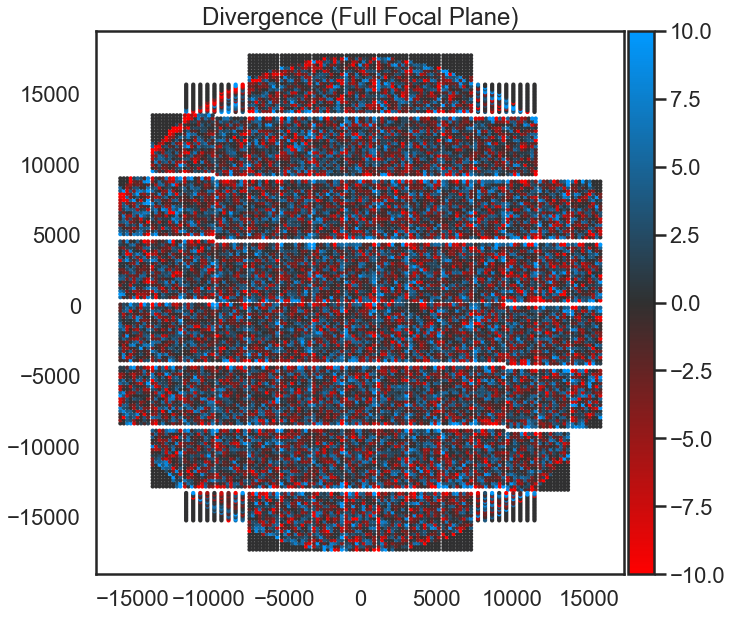

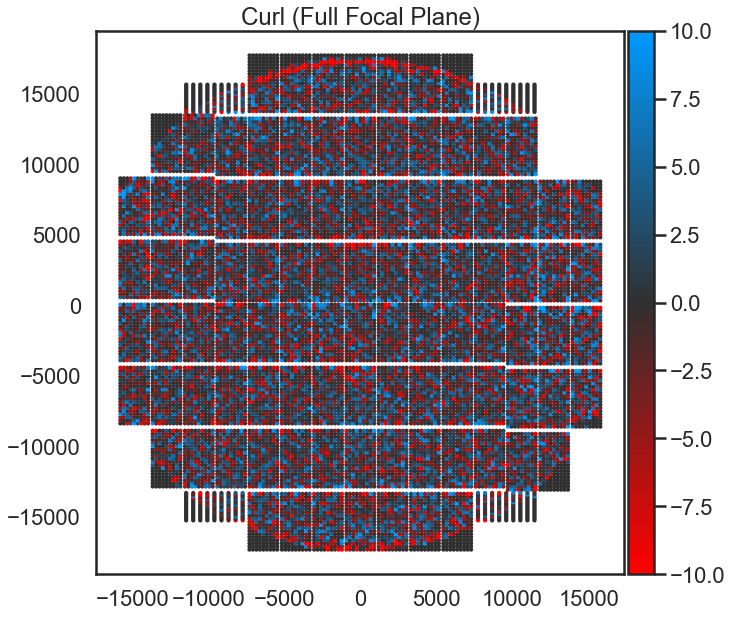

In [89]:
plot_divergence(xMean, yMean, uMean, vMean, dot_size=5)
plot_curl(xMean, yMean, uMean, vMean, dot_size=5)

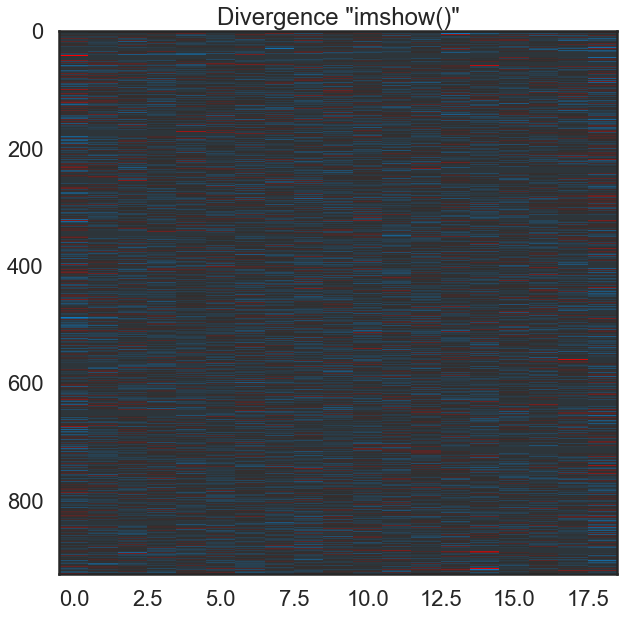

In [52]:
#def imshow_div(xMean, yMean, uMean, vMean):
uDel = np.nan_to_num(np.gradient(uMean))
vDel = np.nan_to_num(np.gradient(vMean))
divergence = uDel[0]+vDel[1] #dudx+dvdy


basic_cols=['#ff0000', '#303030', '#0099ff']
my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
    
plt.figure(figsize=(10,10))
plt.title('Divergence "imshow()"')
plt.imshow(divergence, aspect='auto', cmap=my_cmap);


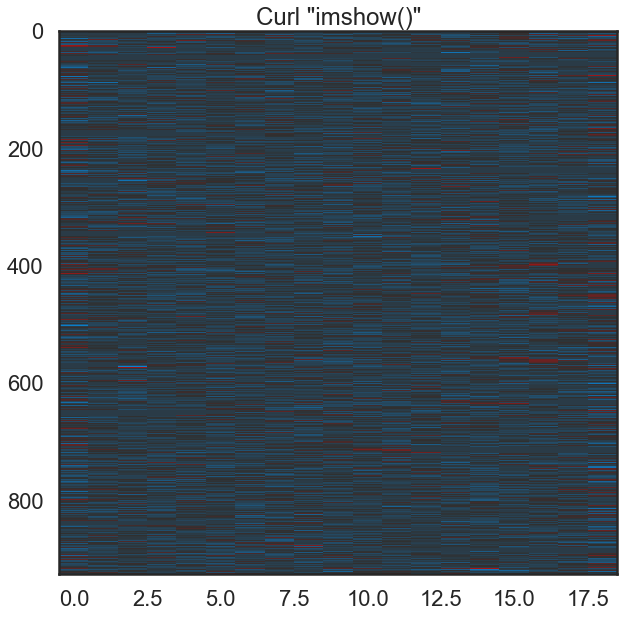

In [53]:
uDel = np.nan_to_num(np.gradient(uMean))
vDel = np.nan_to_num(np.gradient(vMean))
curl = vDel[0]-uDel[1] #dvdx-dudy

plt.figure(figsize=(10,10))
plt.title('Curl "imshow()"')
plt.imshow(curl, aspect='auto',cmap=my_cmap)

In [114]:

def pure_div(n):
    """
    Borrowed from:
    https://scicomp.stackexchange.com/questions/18760/visually-appealing-ways-to-plot-singular-vector-fields-with-matplotlib-or-other
    """
    #X=np.linspace(-n,n,n/2)
    #Y=np.linspace(-n,n,n/2)
    #X,Y=np.meshgrid(X, Y)


    #def E(x,y):
    #    r = np.sqrt(x**6 + y**6)
    #    return (x/r,y/r)

    #def E_dir(x,y):
        #direction field
    #    Ex,Ey = E(x,y)
    #    n = np.sqrt(Ex**2+Ey**2)
        
            
     #   return [Ex/n, Ey/n]

    #Ex,Ey = E(X,Y)
    #U,V = E_dir(X,Y)
    #EE=np.sqrt(Ex**2+Ex**2)
    
    
    x=np.linspace(-n,n,n/2)
    y=np.linspace(-n,n,n/2)
    U,V=np.meshgrid(x, y)
    angle = np.nan_to_num(np.arctan2(V,U))

    plt.figure(figsize=(10,10))
    plt.title('Pure Divergence')
    
    basic_cols=['#ff0000', '#303030', '#0099ff']
    my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
    cmap = "RdGy"   #ListedColormap(seaborn.color_palette('husl',256).as_hex())
    
    Q  = plt.quiver(x, y, U, V, angle, cmap=my_cmap)#, norm=colors.LogNorm(vmin=-n,vmax=n))
    plt.show()
    
    plot_divergence(x,y,U,V, dot_size=20)
    plot_curl(x,y,U,V)

C:\Users\hsham\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Users\hsham\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


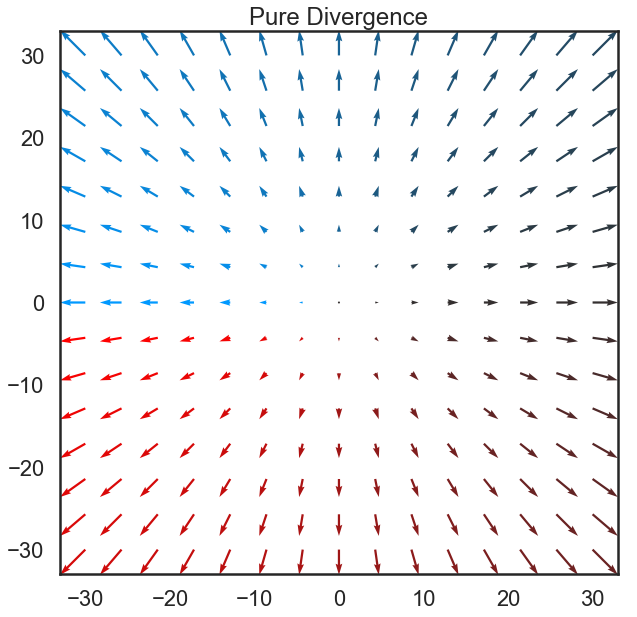

ValueError: 'c' argument has 225 elements, which is not acceptable for use with 'x' with size 15, 'y' with size 15.

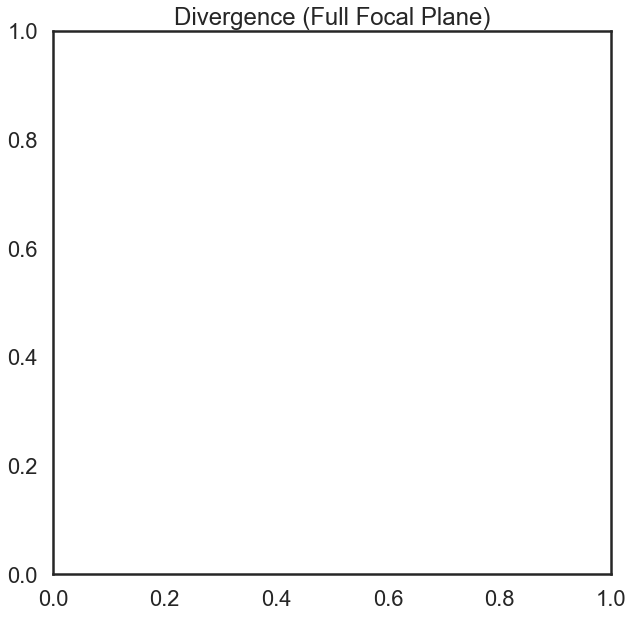

In [115]:
pure_div(30)


In [110]:

def pure_curl(n):
    xx = np.arange(-n,n)
    yy = np.arange(-n,n)
    X, Y = np.meshgrid(xx,yy)
    U = -Y/np.sqrt(X**2+Y**2)
    V = X/np.sqrt(X**2+Y**2)
    angle = np.nan_to_num(np.arctan2(V,U))
#     print(U)
#     print(V)
    
    plt.figure(figsize=(10,10))
    plt.title("Pure Curl")
    
    basic_cols=['#ff0000', '#303030', '#0099ff']
    my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
    cmap = "RdGy"  #ListedColormap(seaborn.color_palette('husl',256).as_hex())
    
    plt.quiver(X, Y, U, V, angle, cmap=my_cmap, pivot='mid')
    plt.show()
    
    plot_divergence(X, Y, U, V, dot_size=100)
    plot_curl(X, Y, U, V, dot_size=100)
    

C:\Users\hsham\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\hsham\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


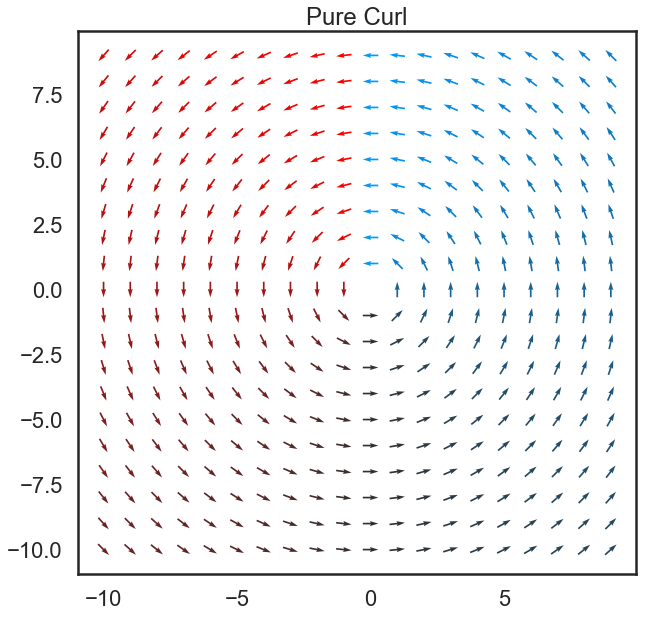

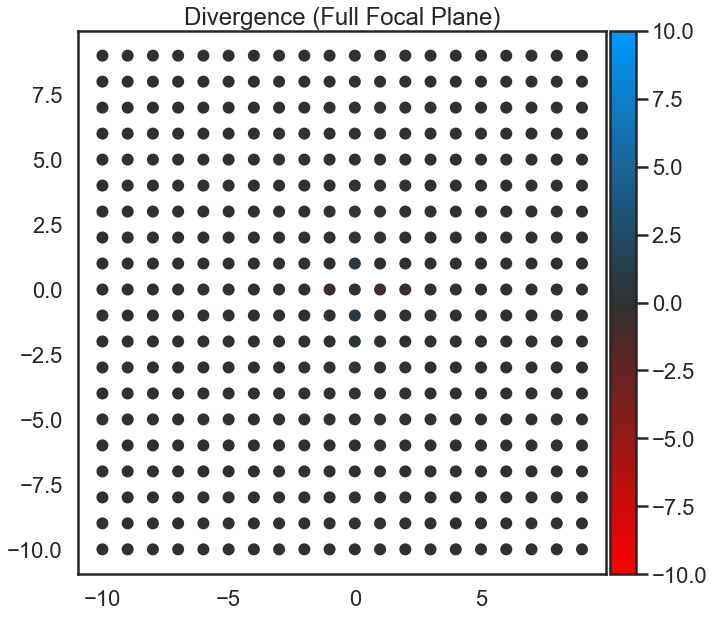

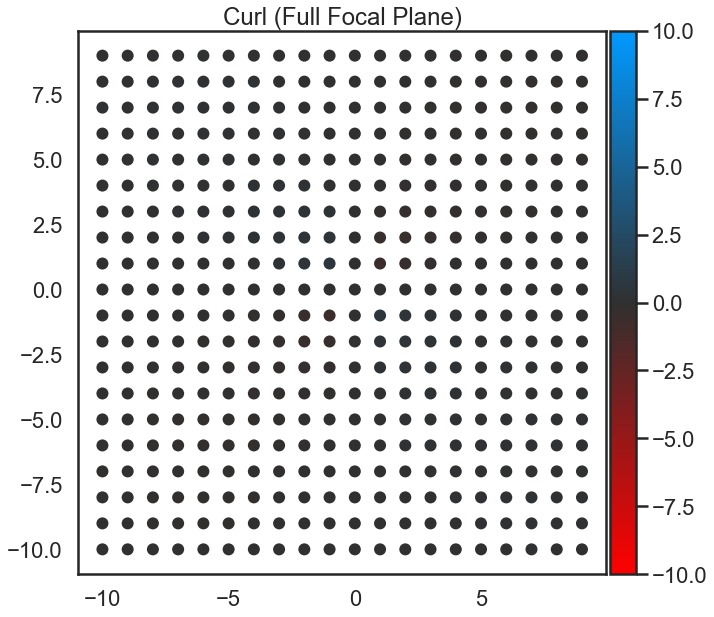

In [111]:
pure_curl(10)